## The NLP Pipeline:
- Sentence Segementation (break document into individual sentences)
- Tokenization (break those sentences into individual words/tokens)
- Parts-of-Speech-Tagging (Input each token as well as a few words around it into a pre trained part-of-speech classification model to recieve the part-of-speech for the token as input)
- Lemmatization (group different forms of the same word)
- Stop Words (exclude common words without any value, such as "and", "the", and "a")
- Depending Parsing (Make sense of how words in sentence relate to each other)
- Noun Phrases (Group nouh phrases together to simplify sentences)
- Named Entity Recognition (tag objects like people's names, company names, geographic locations)
- Corefrence Resolution (Tracking pronouns across sentences to avoid confusion)

In [1]:
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Using Python to extracting stock sentiments from FinViz (good source of information)

To parse the website, add stock ticker to the end of this url: https://finviz.com/quote.ashx?t=

In [2]:
url = 'https://finviz.com/quote.ashx?t=AMZN'

We can use python to parse the website data and perform sentiment analysis for every headline and average it over a period of time.

In [3]:
web_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA', 'AAPL']

for tick in tickers:
    url = web_url + tick
    req = Request(url=url,headers={"User-Agent": "Chrome"})
    response = urlopen(req)
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table')
    news_tables[tick] = news_table

In [5]:
news_tables['GOOG']

<table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer news-table" id="news-table" width="100%">
<tr class="cursor-pointer has-label" onclick="trackAndOpenNews(event, 'MarketWatch', 'https://www.marketwatch.com/livecoverage/meta-earnings-results-stock-revenue-facebook-sales-outlook/card/meta-already-hiked-its-ai-spending-forecast-this-year-is-another-boost-coming--7AKdKCmohrCM2x6E8SwI?mod=mw_FV');">
<td align="right" width="130">
            Today 11:30AM
        </td>
<td align="left">
<div class="news-link-container">
<div class="news-link-left">
<a class="tab-link-news" href="https://www.marketwatch.com/livecoverage/meta-earnings-results-stock-revenue-facebook-sales-outlook/card/meta-already-hiked-its-ai-spending-forecast-this-year-is-another-boost-coming--7AKdKCmohrCM2x6E8SwI?mod=mw_FV" rel="nofollow" target="_blank">Meta already hiked its AI spending forecast this year. Is another boost coming?</a>
</div>
<div class="news-link-right">
<span>(MarketWatch)</spa

Printing the Data & Displaying the contents of `news_tables` for AMZN

In [6]:
amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')

for x, table_row in enumerate(amazon_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if x == 3:
        break

Numerator: Best Buy, Amazon dominate consumer electronics market

            Today 10:56AM
        
UPSs Lead Over FedEx in Market Value Shrinks to Narrowest Ever

            10:48AM
        
Stocks to Watch Wednesday: Hershey, GE HealthCare, Starbucks, SoFi

            09:36AM
        
BMO Lifts Amazon (AMZN) Price Target, Keeps Outperform Rating

            09:12AM
        


C:\Users\kevin\AppData\Local\Temp\ipykernel_13676\3930990292.py:2: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  amazon_tr = amazon.findAll('tr')


Parsing Data into a Python List
- first loop will iterate over the news, and second loop will iterate all over the `<tr>` tags in `news_table`. 

In [ ]:
news_list = []

for file_name, news_table in news_tables.items():
    for i in news_table.findAll('tr'):
        #getting the text within the <tr> tags
        if i.a is not None:
            text = i.a.get_text()

        date_scrape = i.td.text.split()

        #if only one element, then it will only be the time
        if len(date_scrape) == 1:
            time = date_scrape[0]

        #if there is more, then it is date and time
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        tick = file_name.split('_')[0]

        news_list.append([tick, date, time, text])

C:\Users\kevin\AppData\Local\Temp\ipykernel_13676\3422263683.py:4: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for i in news_table.findAll('tr'):


In [11]:
news_list[0:5]

[['AMZN',
  'Today',
  '10:56AM',
  'Numerator: Best Buy, Amazon dominate consumer electronics market'],
 ['AMZN',
  'Today',
  '10:48AM',
  'UPSs Lead Over FedEx in Market Value Shrinks to Narrowest Ever'],
 ['AMZN',
  'Today',
  '09:36AM',
  'Stocks to Watch Wednesday: Hershey, GE HealthCare, Starbucks, SoFi'],
 ['AMZN',
  'Today',
  '09:12AM',
  'BMO Lifts Amazon (AMZN) Price Target, Keeps Outperform Rating'],
 ['AMZN',
  'Today',
  '08:50AM',
  'These 2 Retail and Wholesale Stocks Could Beat Earnings: Why They Should Be on Your Radar']]

## Sentiment Analysis
- We will perform them on the headlines and add an additional column to our DataFrame to store the sentiment scores per headline. 

In [12]:
import nltk
nltk.download("vader_lexicon")#nltk.download()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...


True

- more negative value = more negative sentiment
- more positive value = more positive sentiment

In [ ]:
#parse the date by converting it to datetime form
parse_date = lambda date_str: pd.to_datetime(date_str.lower()).date()

vader = SentimentIntensityAnalyzer()
columns = ['ticker', 'date', 'time', 'headline']

news_df = pd.DataFrame(news_list, columns=columns)

#creates probabilities of each sentiment (negative, neutral, positive)
scores = news_df['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)

news_df = news_df.join(scores_df, rsuffix='_right')
news_df['date'] = news_df['date'].apply(parse_date)#news_df['date'] = pd.to_datetime(news_df.date).dt.date

print(news_df.head(10))

  ticker        date     time  \
0   AMZN  2025-07-30  10:56AM   
1   AMZN  2025-07-30  10:48AM   
2   AMZN  2025-07-30  09:36AM   
3   AMZN  2025-07-30  09:12AM   
4   AMZN  2025-07-30  08:50AM   
5   AMZN  2025-07-30  08:47AM   
6   AMZN  2025-07-30  08:47AM   
7   AMZN  2025-07-30  08:35AM   
8   AMZN  2025-07-30  08:27AM   
9   AMZN  2025-07-30  08:23AM   

                                            headline    neg    neu    pos  \
0  Numerator: Best Buy, Amazon dominate consumer ...  0.121  0.403  0.476   
1  UPSs Lead Over FedEx in Market Value Shrinks t...  0.000  0.806  0.194   
2  Stocks to Watch Wednesday: Hershey, GE HealthC...  0.000  1.000  0.000   
3  BMO Lifts Amazon (AMZN) Price Target, Keeps Ou...  0.000  0.825  0.175   
4  These 2 Retail and Wholesale Stocks Could Beat...  0.000  1.000  0.000   
5  These 2 Retail and Wholesale Stocks Could Beat...  0.000  1.000  0.000   
6  BofA lowers UPS rating to Neutral on uncertain...  0.291  0.709  0.000   
7  Windfall Bios Par

## Plotting: 

In [21]:
plt.rcParams['figure.figsize'] = [10, 6]
mean_scores = news_df.drop(["time","headline"],axis=1).groupby(['ticker','date']).mean()#mean_scores = news_df.groupby(['ticker','date']).mean()
mean_scores

neg       neu       pos  compound
ticker date                                              
AAPL   2025-07-28  0.028500  0.910167  0.061333  0.066700
       2025-07-29  0.041338  0.871446  0.087215  0.100442
       2025-07-30  0.018500  0.869346  0.112154  0.155654
AMZN   2025-07-28  0.033212  0.835333  0.131515  0.184397
       2025-07-29  0.054104  0.817708  0.128188  0.111565
       2025-07-30  0.022955  0.861500  0.115591  0.147755
GOOG   2025-07-28  0.032615  0.859436  0.107974  0.139705
       2025-07-29  0.034816  0.870974  0.094237  0.115711
       2025-07-30  0.022269  0.843577  0.134154  0.185769
TSLA   2025-07-28  0.016500  0.898500  0.085000  0.093983
       2025-07-29  0.037733  0.909967  0.052300  0.034293
       2025-07-30  0.048400  0.816360  0.135240  0.089752

In [22]:
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
mean_scores

ticker,AAPL,AMZN,GOOG,TSLA
date,,,,
2025-07-28,0.066700,0.184397,0.139705,0.093983
2025-07-29,0.100442,0.111565,0.115711,0.034293
2025-07-30,0.155654,0.147755,0.185769,0.089752


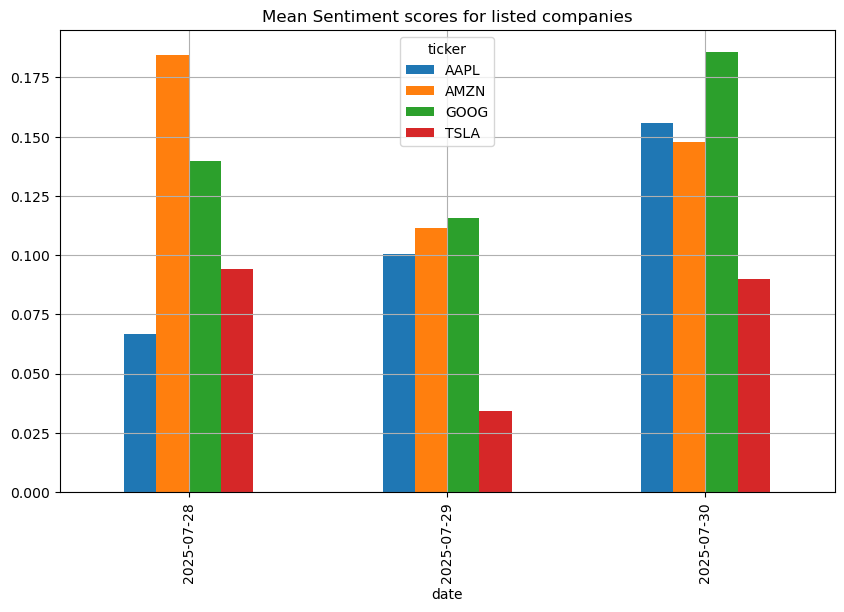

In [23]:
mean_scores.plot(kind = 'bar')
plt.grid()
plt.title("Mean Sentiment scores for listed companies")

plt.show()